In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)


# Stock Price Prediction 

Giới thiệu Project: ###


## Dataset

Giá chứng khoán FPT 

In [299]:
data = pd.read_csv('../dataset/excel_fpt.csv')

In [300]:
data.tail()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3485,FPT,20061219,27.4356,27.4356,27.4356,27.4356,137520
3486,FPT,20061218,26.1371,26.1371,26.1371,26.1372,215790
3487,FPT,20061215,24.8952,24.8952,24.8952,24.8952,265300
3488,FPT,20061214,23.7097,23.7097,23.7097,23.7097,280710
3489,FPT,20061213,22.5807,22.5807,22.5807,22.5807,83530


In [301]:
data.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [302]:
data.shape

(3490, 7)

- Giá tham chiếu: giá Close ngày hôm trước
- Giá Open: giá chốt lệnh lần đầu tiên trong ngày
- Giá High: giá khớp lệnh cao nhất trong ngày
- Giá Low: giá khớp lệnh thấp nhất trong ngày

In [303]:
columns = [i.replace('<', '').replace('>', '') for i in data.columns]

In [304]:
data = data.rename(columns = {data.columns[i]: columns[i] for i in range(len(data.columns))})

In [305]:
data.index = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')
data.drop(columns=['DTYYYYMMDD', 'Ticker'], inplace=True)


In [306]:
data

,Open,High,Low,Close,Volume
DTYYYYMMDD,,,,,
2020-12-16,57.2000,57.5000,57.0000,57.1000,1995530
2020-12-15,57.5000,57.6000,56.6000,56.7000,2666900
2020-12-14,57.0000,58.0000,56.9000,57.2000,1443760
2020-12-11,56.6000,57.0000,56.3000,57.0000,1750270
2020-12-10,57.0000,57.7000,56.5000,56.5000,2112490
...,...,...,...,...,...
2006-12-19,27.4356,27.4356,27.4356,27.4356,137520
2006-12-18,26.1371,26.1371,26.1371,26.1372,215790
2006-12-15,24.8952,24.8952,24.8952,24.8952,265300


Use 2019-2020 range

In [307]:
df = data[data.index.year.isin([2019, 2020])]

<AxesSubplot:xlabel='DTYYYYMMDD'>

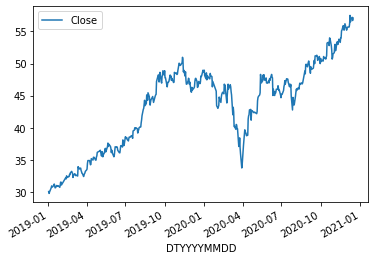

In [308]:
df[['Close']].plot()

Datetime processing

In [309]:
df = df.sort_index()
df.head()

,Open,High,Low,Close,Volume
DTYYYYMMDD,,,,,
2019-01-02,30.5319,30.7876,30.0571,30.0936,459120
2019-01-03,30.2762,30.2762,29.7284,29.8015,716600
2019-01-04,29.6554,30.2763,29.5824,30.0206,318570
2019-01-07,30.5319,30.7510,30.3858,30.5319,408470
2019-01-08,30.5319,30.6780,30.4589,30.6780,295660


In [310]:
df['date'] = df.index
# df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df.drop(columns=['date'], inplace=True)

c:\users\tuantv26\anaconda3\envs\stockpriceforecasting\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


Moving average

In [311]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Close'].rolling(ma).mean()


<AxesSubplot:xlabel='DTYYYYMMDD'>

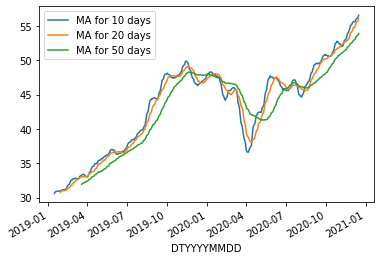

In [312]:
df[['MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()

Shifting values

In [313]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [314]:
for col in cols:
    for i in range(1, 8):
        df[f'{col}_{i}'] = df[col].shift(i)

Set the High_Low limit

`lowerbound = 0.93 * Close_1`

`upperbound = 1.07 * Close_1`

In [315]:
df['lowerbound'] = 0.93 * df['Close_1']
df['upperbound'] = 1.07 * df['Close_1']

In [316]:
df.dropna(how='any', inplace=True)

In [317]:
df.tail()

,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-10,57.0,57.7,56.5,56.5,2112490,3,4,12,2020,345,10,50,55.96,55.370,53.360,56.3,55.7,55.7,55.4,55.5,55.0,55.2,57.8,56.6,56.0,55.9,55.7,55.7,55.4,56.2,55.5,55.5,55.4,55.1,55.0,54.8,57.5,56.2,55.7,55.7,55.6,55.6,55.2,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,2108200.0,3427370.0,53.475,61.525
2020-12-11,56.6,57.0,56.3,57.0,1750270,4,4,12,2020,346,11,50,56.04,55.530,53.494,57.0,56.3,55.7,55.7,55.4,55.5,55.0,57.7,57.8,56.6,56.0,55.9,55.7,55.7,56.5,56.2,55.5,55.5,55.4,55.1,55.0,56.5,57.5,56.2,55.7,55.7,55.6,55.6,2112490.0,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,2108200.0,52.545,60.455
2020-12-14,57.0,58.0,56.9,57.2,1443760,0,4,12,2020,349,14,51,56.22,55.725,53.628,56.6,57.0,56.3,55.7,55.7,55.4,55.5,57.0,57.7,57.8,56.6,56.0,55.9,55.7,56.3,56.5,56.2,55.5,55.5,55.4,55.1,57.0,56.5,57.5,56.2,55.7,55.7,55.6,1750270.0,2112490.0,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,53.010,60.990
2020-12-15,57.5,57.6,56.6,56.7,2666900,1,4,12,2020,350,15,51,56.37,55.860,53.752,57.0,56.6,57.0,56.3,55.7,55.7,55.4,58.0,57.0,57.7,57.8,56.6,56.0,55.9,56.9,56.3,56.5,56.2,55.5,55.5,55.4,57.2,57.0,56.5,57.5,56.2,55.7,55.7,1443760.0,1750270.0,2112490.0,3001820.0,2297110.0,1455180.0,1380920.0,53.196,61.204
2020-12-16,57.2,57.5,57.0,57.1,1995530,2,4,12,2020,351,16,51,56.52,56.015,53.886,57.5,57.0,56.6,57.0,56.3,55.7,55.7,57.6,58.0,57.0,57.7,57.8,56.6,56.0,56.6,56.9,56.3,56.5,56.2,55.5,55.5,56.7,57.2,57.0,56.5,57.5,56.2,55.7,2666900.0,1443760.0,1750270.0,2112490.0,3001820.0,2297110.0,1455180.0,52.731,60.669


Train test split

In [318]:
cols = [i for i in df.columns if i not in ['Open', 'High', 'Low', 'Volume']]
print(cols)

['Close', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days', 'Open_1', 'Open_2', 'Open_3', 'Open_4', 'Open_5', 'Open_6', 'Open_7', 'High_1', 'High_2', 'High_3', 'High_4', 'High_5', 'High_6', 'High_7', 'Low_1', 'Low_2', 'Low_3', 'Low_4', 'Low_5', 'Low_6', 'Low_7', 'Close_1', 'Close_2', 'Close_3', 'Close_4', 'Close_5', 'Close_6', 'Close_7', 'Volume_1', 'Volume_2', 'Volume_3', 'Volume_4', 'Volume_5', 'Volume_6', 'Volume_7', 'lowerbound', 'upperbound']


In [319]:
df = df[cols]
label_col = 'Close'

In [320]:
from sklearn.model_selection import train_test_split

In [321]:
def get_data_splits(df, train_ratio: float, validation_ratio: float, test_ratio: float):
    train_len = int(df.shape[0] * train_ratio)
    train_data = df.iloc[: train_len]
    test_len = int(df.shape[0] * test_ratio)
    test_data = df.iloc[-test_len:]
    val_data = df.iloc[train_len:-test_len]
    return train_data, val_data, test_data

In [322]:
train_data, _, test_data = get_data_splits(df, train_ratio=0.5, validation_ratio=0, test_ratio=0.5)


In [323]:
train_data

,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-19,33.3806,1,1,3,2019,78,19,12,33.26005,33.040915,31.929930,33.8188,33.7823,33.7458,33.9649,32.6866,32.6136,32.6502,33.9284,33.8188,33.9649,34.1110,33.9649,32.7597,32.7232,33.5632,33.4171,33.5997,33.7458,32.6866,32.4675,32.4676,33.7458,33.5997,33.7823,33.7458,33.9649,32.5040,32.6136,994080.0,1041840.0,533480.0,1001890.0,1930870.0,364520.0,693180.0,31.383594,36.108006
2019-03-20,33.1980,2,1,3,2019,79,20,12,33.32214,33.062830,31.992018,33.7458,33.8188,33.7823,33.7458,33.9649,32.6866,32.6136,33.8188,33.9284,33.8188,33.9649,34.1110,33.9649,32.7597,33.3806,33.5632,33.4171,33.5997,33.7458,32.6866,32.4675,33.3806,33.7458,33.5997,33.7823,33.7458,33.9649,32.5040,914720.0,994080.0,1041840.0,533480.0,1001890.0,1930870.0,364520.0,31.043958,35.717242
2019-03-21,32.9423,3,1,3,2019,80,21,12,33.34770,33.073785,32.054834,33.3076,33.7458,33.8188,33.7823,33.7458,33.9649,32.6866,33.5267,33.8188,33.9284,33.8188,33.9649,34.1110,33.9649,33.0519,33.3806,33.5632,33.4171,33.5997,33.7458,32.6866,33.1980,33.3806,33.7458,33.5997,33.7823,33.7458,33.9649,797270.0,914720.0,994080.0,1041840.0,533480.0,1001890.0,1930870.0,30.874140,35.521860
2019-03-22,32.9058,4,1,3,2019,81,22,12,33.37692,33.068310,32.112538,33.4537,33.3076,33.7458,33.8188,33.7823,33.7458,33.9649,33.4537,33.5267,33.8188,33.9284,33.8188,33.9649,34.1110,32.9423,33.0519,33.3806,33.5632,33.4171,33.5997,33.7458,32.9423,33.1980,33.3806,33.7458,33.5997,33.7823,33.7458,825740.0,797270.0,914720.0,994080.0,1041840.0,533480.0,1001890.0,30.636339,35.248261
2019-03-25,32.4310,0,1,3,2019,84,25,13,33.36962,33.028135,32.150520,32.9423,33.4537,33.3076,33.7458,33.8188,33.7823,33.7458,33.1614,33.4537,33.5267,33.8188,33.9284,33.8188,33.9649,32.9058,32.9423,33.0519,33.3806,33.5632,33.4171,33.5997,32.9058,32.9423,33.1980,33.3806,33.7458,33.5997,33.7823,687690.0,825740.0,797270.0,914720.0,994080.0,1041840.0,533480.0,30.602394,35.209206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-30,45.7140,3,1,1,2020,30,30,5,47.49409,47.882700,47.402154,45.9647,48.3047,48.0540,48.4719,47.6362,47.6362,47.7197,47.2183,48.4718,48.4719,48.5555,48.6391,47.7198,47.9704,45.7140,46.3825,47.8033,47.6362,47.6362,47.4691,47.6361,47.2183,46.3826,47.9704,48.1376,48.4719,47.6362,47.6362,3165650.0,4351820.0,1227100.0,1388810.0,1942970.0,940870.0,721680.0,43.913019,50.523581
2020-01-31,43.4575,4,1,1,2020,31,31,5,47.03444,47.657055,47.296852,46.2154,45.9647,48.3047,48.0540,48.4719,47.6362,47.6362,46.6333,47.2183,48.4718,48.4719,48.5555,48.6391,47.7198,45.0454,45.7140,46.3825,47.8033,47.6362,47.6362,47.4691,45.7140,47.2183,46.3826,47.9704,48.1376,48.4719,47.6362,2638460.0,3165650.0,4351820.0,1227100.0,1388810.0,1942970.0,940870.0,42.514020,48.913980
2020-02-03,43.0397,0,1,2,2020,34,3,6,46.56644,47.402160,47.178180,45.1290,46.2154,45.9647,48.3047,48.0540,48.4719,47.6362,45.8811,46.6333,47.2183,48.4718,48.4719,48.5555,48.6391,43.4576,45.0454,45.7140,46.3825,47.8033,47.6362,47.6362,43.4575,45.7140,47.2183,46.3826,47.9704,48.1376,48.4719,4118150.0,2638460.0,3165650.0,4351820.0,1227100.0,1388810.0,1942970.0,40.415475,46.499525


In [324]:
test_data

,Close,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA for 10 days,MA for 20 days,MA for 50 days,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,High_1,High_2,High_3,High_4,High_5,High_6,High_7,Low_1,Low_2,Low_3,Low_4,Low_5,Low_6,Low_7,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Volume_1,Volume_2,Volume_3,Volume_4,Volume_5,Volume_6,Volume_7,lowerbound,upperbound
DTYYYYMMDD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-06,44.7947,3,1,2,2020,37,6,6,45.34627,46.64583,46.924120,43.7083,43.7919,41.4518,45.1290,46.2154,45.9647,48.3047,44.1261,43.7919,43.8754,45.8811,46.6333,47.2183,48.4718,43.4575,42.6218,40.9503,43.4576,45.0454,45.7140,46.3825,43.4575,43.2904,43.0397,43.4575,45.7140,47.2183,46.3826,1648620.0,1651440.0,3602970.0,4118150.0,2638460.0,3165650.0,4351820.0,40.415475,46.499525
2020-02-07,44.5440,4,1,2,2020,38,7,6,44.98691,46.46615,46.878992,43.8754,43.7083,43.7919,41.4518,45.1290,46.2154,45.9647,44.7947,44.1261,43.7919,43.8754,45.8811,46.6333,47.2183,43.2904,43.4575,42.6218,40.9503,43.4576,45.0454,45.7140,44.7947,43.4575,43.2904,43.0397,43.4575,45.7140,47.2183,1708550.0,1648620.0,1651440.0,3602970.0,4118150.0,2638460.0,3165650.0,41.659071,47.930329
2020-02-10,43.9590,0,1,2,2020,41,10,7,44.58577,46.28229,46.822164,44.2933,43.8754,43.7083,43.7919,41.4518,45.1290,46.2154,44.7111,44.7947,44.1261,43.7919,43.8754,45.8811,46.6333,44.1261,43.2904,43.4575,42.6218,40.9503,43.4576,45.0454,44.5440,44.7947,43.4575,43.2904,43.0397,43.4575,45.7140,1218660.0,1708550.0,1648620.0,1651440.0,3602970.0,4118150.0,2638460.0,41.425920,47.662080
2020-02-11,44.7947,1,1,2,2020,42,11,7,44.42698,46.09425,46.772020,43.7918,44.2933,43.8754,43.7083,43.7919,41.4518,45.1290,44.2933,44.7111,44.7947,44.1261,43.7919,43.8754,45.8811,43.5411,44.1261,43.2904,43.4575,42.6218,40.9503,43.4576,43.9590,44.5440,44.7947,43.4575,43.2904,43.0397,43.4575,738090.0,1218660.0,1708550.0,1648620.0,1651440.0,3602970.0,4118150.0,40.881870,47.036130
2020-02-12,45.2126,2,1,2,2020,43,12,7,44.22641,45.98143,46.721878,44.2097,43.7918,44.2933,43.8754,43.7083,43.7919,41.4518,44.8783,44.2933,44.7111,44.7947,44.1261,43.7919,43.8754,44.0426,43.5411,44.1261,43.2904,43.4575,42.6218,40.9503,44.7947,43.9590,44.5440,44.7947,43.4575,43.2904,43.0397,1085380.0,738090.0,1218660.0,1708550.0,1648620.0,1651440.0,3602970.0,41.659071,47.930329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-10,56.5000,3,4,12,2020,345,10,50,55.96000,55.37000,53.360000,56.3000,55.7000,55.7000,55.4000,55.5000,55.0000,55.2000,57.8000,56.6000,56.0000,55.9000,55.7000,55.7000,55.4000,56.2000,55.5000,55.5000,55.4000,55.1000,55.0000,54.8000,57.5000,56.2000,55.7000,55.7000,55.6000,55.6000,55.2000,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,2108200.0,3427370.0,53.475000,61.525000
2020-12-11,57.0000,4,4,12,2020,346,11,50,56.04000,55.53000,53.494000,57.0000,56.3000,55.7000,55.7000,55.4000,55.5000,55.0000,57.7000,57.8000,56.6000,56.0000,55.9000,55.7000,55.7000,56.5000,56.2000,55.5000,55.5000,55.4000,55.1000,55.0000,56.5000,57.5000,56.2000,55.7000,55.7000,55.6000,55.6000,2112490.0,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,2108200.0,52.545000,60.455000
2020-12-14,57.2000,0,4,12,2020,349,14,51,56.22000,55.72500,53.628000,56.6000,57.0000,56.3000,55.7000,55.7000,55.4000,55.5000,57.0000,57.7000,57.8000,56.6000,56.0000,55.9000,55.7000,56.3000,56.5000,56.2000,55.5000,55.5000,55.4000,55.1000,57.0000,56.5000,57.5000,56.2000,55.7000,55.7000,55.6000,1750270.0,2112490.0,3001820.0,2297110.0,1455180.0,1380920.0,1627980.0,53.010000,60.990000


In [325]:
X_train, y_train = train_data.drop(columns=[label_col]), train_data[label_col]
X_test, y_test = test_data.drop(columns=[label_col]), test_data[label_col]

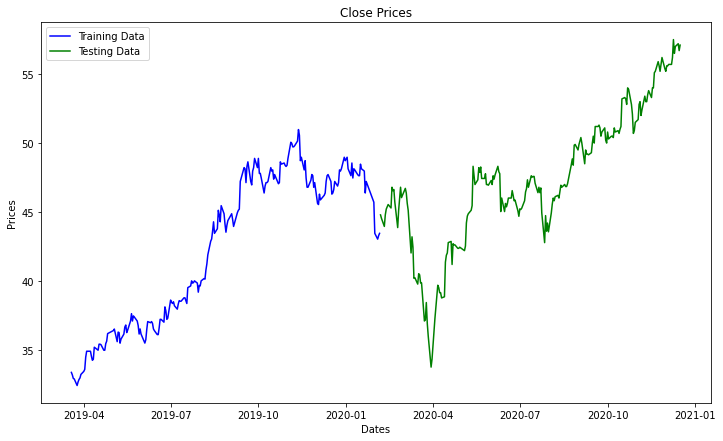

In [326]:
plt.figure(figsize=(12,7))
plt.title('Close Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(y_train, 'blue', label='Training Data')
plt.plot(y_test, 'green', label='Testing Data')
plt.legend()


## Baseline

Linear Regression

In [327]:
from sklearn.linear_model import LinearRegression

In [328]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

Evaluate

In [329]:
from sklearn.metrics import mean_squared_error, r2_score

In [330]:
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100


In [331]:
y_pred = linear_reg.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)
MAPE(y_test, y_pred)

1.2084317585856728

In [332]:
mean_squared_error(y_test, y_pred)

0.5420373752028698

In [333]:
r2_score(y_test, y_pred)

0.976871443356812

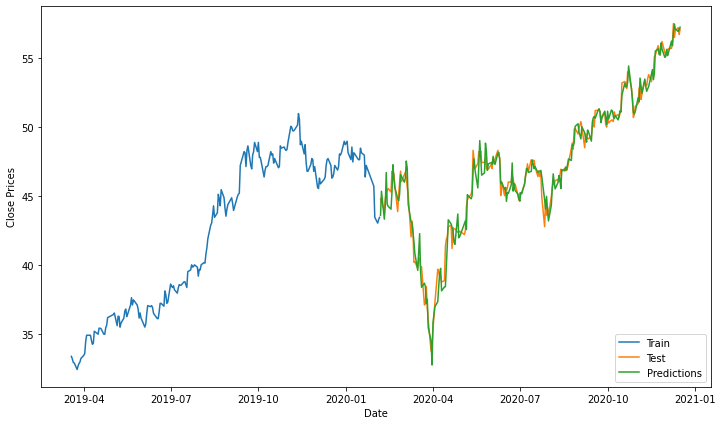

In [334]:
plt.figure(figsize=(12, 7))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(y_train)
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()